In [ ]:
# https://nthu-datalab.github.io/ml/labs/12-2_Visualization_Style-Transfer/12-2_Visualization_Style-Transfer.html

In [1]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [2]:
!nvidia-smi

Tue Nov 16 14:36:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 N/A |                  N/A |
| 27%    0C    P0    N/A /  N/A |   1552MiB /  2048MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]
    
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

# Part I : A Neural Algorithm of Artistic Style

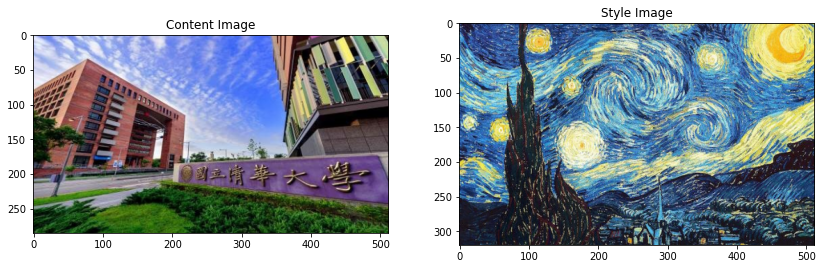

In [5]:
# content_path = '/content/drive/MyDrive/Colab Notebooks/dataset/content_nthu.jpg'
# style_path = '/content/drive/MyDrive/Colab Notebooks/dataset/style_starry_night.jpg'

content_path = 'dataset/content.jpg'
style_path = 'dataset/style2.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 320, 512, 64)
  min:  0.0
  max:  806.44794
  mean:  31.06276

block2_conv1
  shape:  (1, 160, 256, 128)
  min:  0.0
  max:  3698.6194
  mean:  194.2081

block3_conv1
  shape:  (1, 80, 128, 256)
  min:  0.0
  max:  8943.063
  mean:  193.57497

block4_conv1
  shape:  (1, 40, 64, 512)
  min:  0.0
  max:  17731.176
  mean:  712.596

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  3545.856
  mean:  57.81787



In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}


In [11]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

style_results = results['style']
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 0
content_weight = 0
# print('Styles:')
# for name, output in sorted(results['style'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())
#     print()

# print("Contents:")
# for name, output in sorted(results['content'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())

In [12]:
def style_content_loss(outputs, content_weight, style_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Implement Total Variation Loss

In [13]:
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d for d in tensor.get_shape()), 1)

def total_variation_loss(image, tv_weight):
    # TODO   
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:image.shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:image.shape[2]-1,:]) /
          tv_x_size))
    return tv_loss

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# @tf.function
def train_step(image, content_weight, style_weight, tv_weight, style_layers, content_layers):
    with tf.GradientTape() as tape:
        extractor = StyleContentModel(style_layers, content_layers)
        outputs = extractor(image)
        loss = style_content_loss(outputs, content_weight=content_weight, style_weight=style_weight)
        loss += total_variation_loss(image, tv_weight)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


In [14]:
# content_weight = 5e1
# style_weight = 5e1
# total_variation_weight = 100

def customize_stylish(content_image, epochs, steps_per_epoch, content_weight, style_weight, total_variation_weight, style_layers, content_layers):
  image = tf.Variable(content_image)
  start = time.time()

  step = 0
  for n in range(epochs):
      for m in range(steps_per_epoch):
          step += 1
          train_step(image, content_weight=content_weight,style_weight=style_weight,tv_weight=total_variation_weight, style_layers=style_layers, content_layers=content_layers)
  imshow(image.read_value())
  # plt.title("Train step: {}".format(step))
  plt.show()

  end = time.time()
  print("Total time: {:.1f}".format(end-start))

# Change the weights for the style, content, and total variational loss

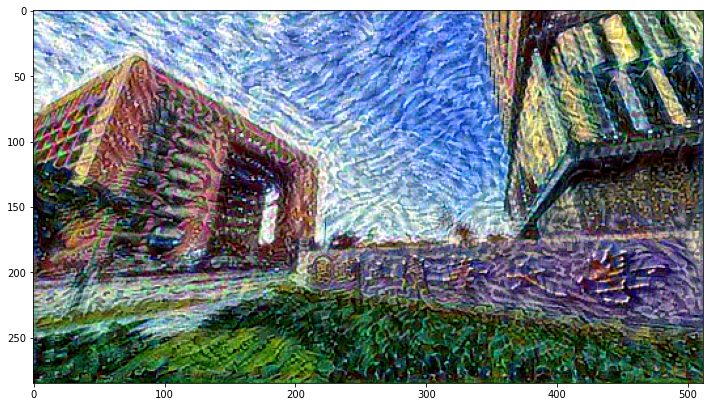

Total time: 140.8


In [15]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# customize_stylish(content_image=content_image, epochs=5, steps_per_epoch=10, content_weight=1e0, style_weight=1e5, total_variation_weight=0)
customize_stylish(content_image=content_image, 
                  epochs=3, 
                  steps_per_epoch=10, 
                  content_weight=1e0, 
                  style_weight=1e5, 
                  total_variation_weight=0, 
                  style_layers=style_layers, 
                  content_layers=content_layers)

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


customize_stylish(content_image=content_image, 
                  epochs=5, 
                  steps_per_epoch=10, 
                  content_weight=1e5, 
                  style_weight=1e0, 
                  total_variation_weight=0, 
                  style_layers=style_layers, 
                  content_layers=content_layers)

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


customize_stylish(content_image=content_image, 
                  epochs=5, 
                  steps_per_epoch=10, 
                  content_weight=1e5, 
                  style_weight=1e5, 
                  total_variation_weight=0, 
                  style_layers=style_layers, 
                  content_layers=content_layers)

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


customize_stylish(content_image=content_image, 
                  epochs=5, 
                  steps_per_epoch=10, 
                  content_weight=1e5, 
                  style_weight=1e5, 
                  total_variation_weight=1e2, 
                  style_layers=style_layers, 
                  content_layers=content_layers)

# Use other layers in the model

In [ ]:
# for layer in vgg.layers:
#     print(layer.name)
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1', 
                'block3_conv1', 
                ]

customize_stylish(content_image=content_image, 
                  epochs=1, 
                  steps_per_epoch=10, 
                  content_weight=1e2, 
                  style_weight=1e2, 
                  total_variation_weight=1e2, 
                  style_layers=style_layers, 
                  content_layers=content_layers)

In [ ]:
# for layer in vgg.layers:
#     print(layer.name)
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block3_conv1',
                'block4_conv1',
                'block5_conv1']

customize_stylish(content_image=content_image, 
                  epochs=5, 
                  steps_per_epoch=100, 
                  content_weight=1e2, 
                  style_weight=1e2, 
                  total_variation_weight=1e2, 
                  
                  style_layers=style_layers, 
                  content_layers=content_layers)

# Report

---
**首先是通過改變style_weight(sw), content_weight(cw) 以及 total_variational_weight(vw)， 我做了以下的設定：**
*   content_weight=1e0, style_weight=1e5, total_variational_weight=0
*   content_weight=1e5, style_weight=1e0, total_variational_weight=0
*   content_weight=1e5, style_weight=1e5, total_variational_weight=0
*   content_weight=1e5, style_weight=1e5, total_variational_weight=1e2

可以看到的是，隨著content_weight的權重增加，圖像的內容元素（建築物的輪廓）會更清晰，相反的，如果style_weight增加，建築物的輪廓越模糊，形態越接近style的pattern。

而total_variational_weight的增加，則是可以通過尋找相鄰pixel間的關係，試著做smoothing的行為，從而讓content和style對圖像的表現有一個平衡!

---

**接著是使用不同的layers來看影響，為了有更明顯的比對效果，我content_layers一致使用一樣的layers, 而對style_layers做改變觀察：**
*   Experiment 1: [ block1_conv1, block2_conv1, block3_conv1 ]
*   Experiment 2: [ block3_conv1, block4_conv1, block5_conv1 ]

可以看到結果在style_weight和content_weight一樣的情況下，Experiment1 ,2 兩個Experiment分別帶給圖像style結果較淺和style結果較深。 因此可得知越深的style layers的Receptive Field更大，對content模擬出的style的表現也越明顯！

# Part II : AdaIN

In [23]:
%matplotlib inline

CONTENT_DIRS = './test2014-001'
STYLE_DIRS = './test-001'

# VGG19 was trained by Caffe which converted images from RGB to BGR,
# then zero-centered each color channel with respect to the ImageNet 
# dataset, without scaling.  
IMG_MEANS = np.array([103.939, 116.779, 123.68]) # BGR

IMG_SHAPE = (224, 224, 3) # training image shape, (h, w, c)
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 32
EPOCHS = 30
STEPS_PER_EPOCH = 12000 // BATCH_SIZE

In [27]:
def sample_files(dir, num, pattern='**/*.jpg'):
    '''Samples files in a directory using the reservoir sampling.'''

    paths = Path(dir).glob(pattern) # list of Path objects
    sampled = []
    for i, path in enumerate(paths):
        if i < num:
            sampled.append(path) 
        else:
            s = random.randint(0, i)
            if s < num:
                sampled[s] = path
    return sampled

def plot_images(dir, row, col, pattern):
    paths = sample_files(dir, row*col, pattern)
    print(len(paths))
    # plt.figure(figsize=(2*col, 2*row))
    # for i in range(row*col):
    #     im = Image.open(paths[i])
    #     w, h = im.size

    #     plt.subplot(row, col, i+1)
    #     plt.imshow(im)
    #     plt.grid(False)
    #     plt.xticks([])
    #     plt.yticks([])
    #     plt.xlabel(f'{w}x{h}')
    # plt.show()

print('Sampled content images:')
plot_images(CONTENT_DIRS, 4, 8, pattern='*.jpg')

print('Sampled style images:')
plot_images(STYLE_DIRS, 4, 8, pattern='*.jpg')

Sampled content images:
0
Sampled style images:
0
